<a href="https://colab.research.google.com/github/Abdelrahman-Alkhodary/Computer-Vision_with_tensorflow/blob/main/CNN_TF_Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Input, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteL5NYBP/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmp5zlqb796tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*dataset_size))

  val_test_dataset  = dataset.skip(int(TRAIN_RATIO*dataset_size))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*dataset_size))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO*dataset_size))
  return train_dataset, val_dataset, test_dataset

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [7]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2755, 2757)

# **Data Visualization**

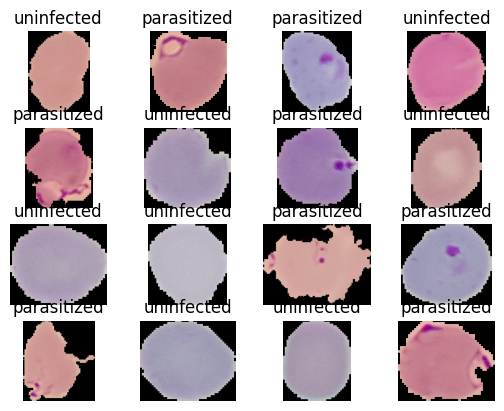

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [9]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(145, 148, 3)
(133, 127, 3)
(118, 118, 3)
(124, 121, 3)
(151, 148, 3)
(151, 130, 3)
(139, 175, 3)
(151, 139, 3)
(160, 148, 3)
(124, 130, 3)
(133, 136, 3)
(145, 163, 3)
(112, 115, 3)
(133, 133, 3)
(166, 184, 3)
(136, 130, 3)


In [10]:
# we will define a function to resize the image of the dataset as images have different sizes
# new image size will be square of 224
IM_SIZE = 224
def resizing_rescaling(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label

In [11]:
train_dataset = train_dataset.map(resizing_rescaling)

In [12]:
val_dataset = val_dataset.map(resizing_rescaling)

test_dataset = test_dataset.map(resizing_rescaling)

In [13]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


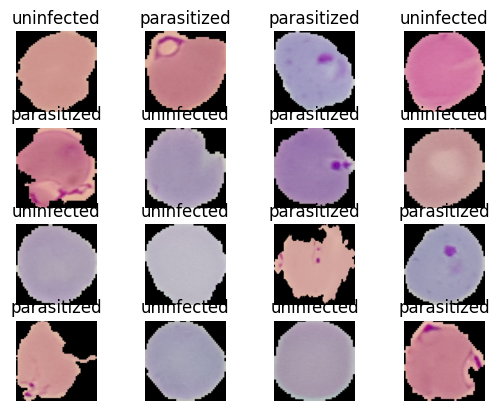

In [14]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [15]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
from keras.src.layers.serialization import activation
from keras.src.engine.training import input_ops
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(),
    metrics='accuracy'
)

In [18]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 56s 63ms/step - loss: 0.6664 - accuracy: 0.5938 - val_loss: 0.7387 - val_accuracy: 0.4933
Epoch 2/20
689/689 [==============================] - 42s 61ms/step - loss: 0.6832 - accuracy: 0.5635 - val_loss: 0.6697 - val_accuracy: 0.5851
Epoch 3/20
689/689 [==============================] - 50s 72ms/step - loss: 0.4202 - accuracy: 0.8078 - val_loss: 1.2363 - val_accuracy: 0.7924
Epoch 4/20
689/689 [==============================] - 42s 61ms/step - loss: 0.2464 - accuracy: 0.9252 - val_loss: 0.3816 - val_accuracy: 0.8624
Epoch 5/20
689/689 [==============================] - 41s 60ms/step - loss: 0.2259 - accuracy: 0.9340 - val_loss: 1.0901 - val_accuracy: 0.8363
Epoch 6/20
689/689 [==============================] - 44s 63ms/step - loss: 0.2146 - accuracy: 0.9356 - val_loss: 0.2349 - val_accuracy: 0.9191
Epoch 7/20
689/689 [==============================] - 46s 66ms/step - loss: 0.2011 - accuracy: 0.9402 - val_loss: 0.2663 - val_accuracy:

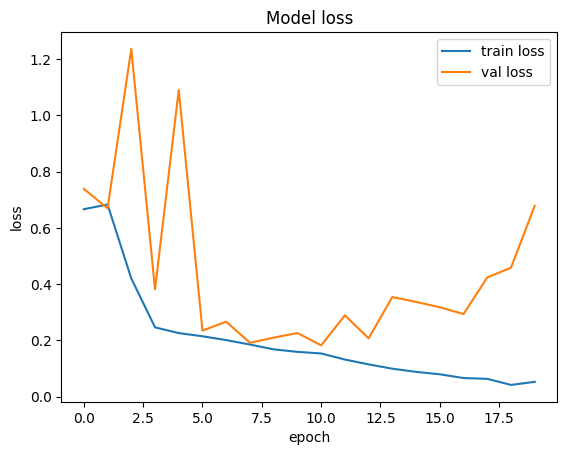

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

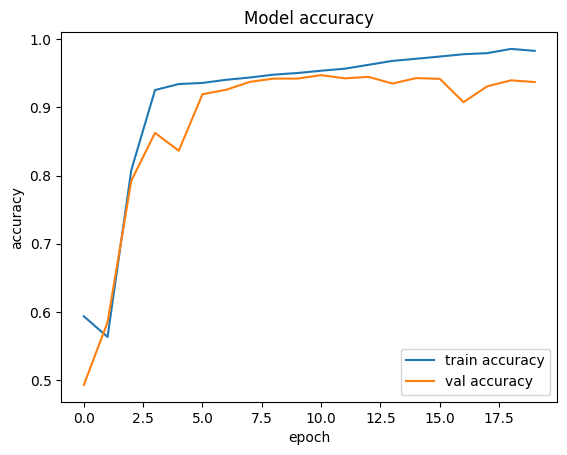

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [21]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 0.6259 - accuracy: 0.9343


[0.6259070038795471, 0.9343489408493042]

In [23]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 10s 10s/step


array([[0.9999999]], dtype=float32)

In [24]:
def label_define(x):
  if x<0.5:
    return str('P')
  else:
    return str('U')

In [25]:
label_define(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 10s 10s/step


'P'

In [26]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 10s 10s/step


1.0

1/1 [==============================] - 0s 19ms/step


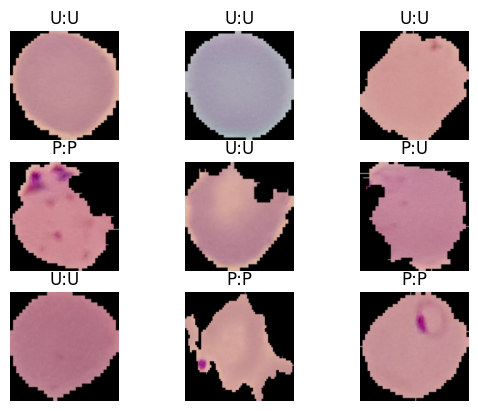

In [27]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(label_define(label.numpy()[0])) + ':' + str(label_define(model.predict(image)[0][0])))
  plt.axis('off')
  # plt.show()

In [28]:
# save the model configuration and the model's weights
model.save('LenetSavedModel')

In [29]:
lenet_loaded_model = tf.keras.models.load_model('LenetSavedModel')
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [30]:
lenet_loaded_model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.6193 - accuracy: 0.9351


[0.6193439960479736, 0.9350743293762207]

In [31]:
model.save('Lenet.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
lenet_loaded_model = tf.keras.models.load_model('Lenet.hdf5')
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [33]:
# save only the model's weights
model.save_weights('weights/lenet_weights')

Saving to Google Drive

In [36]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [37]:
# copy the model to the drive
!cp -r /content/LenetSavedModel/ /content/drive/MyDrive/lenet/

# Functional API

In [38]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name='Feature_Extractor')
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [39]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = feature_extractor_model(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name='Lenet_Modle')

lenet_model.summary()

Model: "Lenet_Modle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                

# Model Subclassing

In [42]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation) -> None:
    super(FeatureExtractor, self).__init__()
    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=2, strides=2)

    self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=2, strides=2)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(6, 3, (1,1), 'valid', 'relu')

In [43]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = feature_sub_classed(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name='Lenet_Modle')

lenet_model.summary()

Model: "Lenet_Modle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 6)         546       
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 17496)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               1749700   
                                                                 
 batch_normalization_10 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [47]:
class LenetModel(Model):
  def __init__(self) -> None:
    super(LenetModel, self).__init__()
    self.feature_sub_classed = FeatureExtractor(6, 3, (1,1), 'valid', 'relu')

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation='sigmoid')

  def call(self, x):

    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x


model_sub_classed = LenetModel()
model_sub_classed(tf.zeros((1,244,244,3)))
model_sub_classed.summary()

Model: "lenet_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_3 (Featu  multiple                  0 (unused)
 reExtractor)                                                    
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_17 (Dense)            multiple                  17860900  
                                                                 
 batch_normalization_26 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_18 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_27 (Ba  multiple                

In [48]:
model_sub_classed.compile(optimizer=Adam(learning_rate=0.01),
                          loss=BinaryCrossentropy(),
                          metrics='accuracy')